# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)# установим формат для чисел с плавующей точкой
pd.set_option('display.max_columns', None)# добавим вижен по всем столбцам 

data = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')#добавим сепаратор \t, так-то лучше
data['index'] = data.index# может пригодиться, копия индекса

In [2]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,index
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,nan,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan,0
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00,1
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,2
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,False,False,nan,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00,3
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,nan,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00,4


In [3]:
data.info()# оценим столбцы с пропусками

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

**Вывод**

1. Данные как  данные, есть пропуски. Отдельно в пункте предобработка данных оценим причины пропусков, предложим логическую замену, если потребуется. 
2. first_day_exposition, is_apartment- тип данных object переведем в приятный для чтения формат как человеку, так и компьютеру по мере выполнения задач в  проекте.

## Предобработка данных

#### Замена типов  данных

In [4]:
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'],yearfirst=True, format='%Y.%m.%d') # приведем столбец к типу данных Дата
data['balcony'].fillna(0).astype('int32') # не бывает пол балкона, сразу проведем преобразование
data[['last_price','rooms','floor']]= data[['last_price','rooms','floor']].astype('int32',errors = 'ignore') #цены без копеек,избавимся от float. Комнаты и этаж сделаем также int32
data['is_apartment']=data['is_apartment'].fillna(False).astype('bool') # заменим на булево значение False,если прямо не указано, что апартаменты, значит их нет.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null int32
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int32
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int32
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_arou

**Вывод** В целом, поменяли основное. Оbject остался только у названий населенных пунктов, остальные типы данных числовые, тем удобнее, проще будет считать.Если будет необходимо поменяем на Int по ходу выполнения работы. first_day_exposition(дата публикации)  перевели в тип данных дата

#### Оценка корректности данных

In [6]:
data.kitchen_area.describe()# посмотрим как там люди живут.

count   21421.00
mean       10.57
std         5.91
min         1.30
25%         7.00
50%         9.10
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

In [7]:
# data.total_area.sort_values(ascending=False)# посмотрим как там люди живут
# data.total_area.sort_values()# есть квартиры  с общей площадью 2-5 кв.м, наверное, это нора.
data.query('total_area>500')# смотрим аномалии, похоже на правду

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,index
3117,19,140000000,631.00,2019-03-30,7,nan,5.00,nan,5,False,False,False,60.00,nan,Санкт-Петербург,25707.00,4972.00,0.00,nan,2.00,210.00,nan,3117
4237,1,50000000,517.00,2017-10-14,7,nan,4.00,332.00,3,False,False,False,22.00,nan,Санкт-Петербург,22835.00,1847.00,2.00,477.00,2.00,540.00,nan,4237
5358,20,65000000,590.00,2019-02-14,15,3.50,6.00,409.00,3,False,False,False,100.00,nan,Санкт-Петербург,24447.00,4666.00,1.00,767.00,0.00,nan,14.00,5358
8018,20,84000000,507.00,2015-12-17,5,4.45,7.00,301.50,7,True,False,False,45.50,1.00,Санкт-Петербург,nan,5735.00,2.00,110.00,0.00,nan,1078.00,8018
12859,20,140000000,631.20,2019-04-09,7,3.90,4.00,322.30,4,False,False,False,19.50,1.00,Санкт-Петербург,25707.00,4972.00,0.00,nan,2.00,210.00,nan,12859
15651,20,300000000,618.00,2017-12-18,7,3.40,7.00,258.00,5,False,False,False,70.00,nan,Санкт-Петербург,32440.00,5297.00,0.00,nan,2.00,198.00,111.00,15651
19540,8,420000000,900.00,2017-12-06,12,2.80,25.00,409.70,25,False,False,False,112.00,nan,Санкт-Петербург,30706.00,7877.00,0.00,nan,2.00,318.00,106.00,19540


In [8]:
data.last_price.describe().astype(int).apply('{:,}'.format)# цена на момент снятия с публикации - медиана отличается от среднего значения, из это седует, что какие-то экстримальные значение тянут среднее значение вверх.Возможно, это некое элитное жилье
# data.query('last_price>200000000').sort_values('last_price',ascending=False)# не долго квартира около 1ккк стояла до снятия

count         23,699
mean       6,541,548
std       10,887,013
min           12,190
25%        3,400,000
50%        4,650,000
75%        6,800,000
max      763,000,000
Name: last_price, dtype: object

In [9]:
data.total_area.describe().astype(int)# площадь квартиры в квадратных метрах (м²) - есть экстремальные выбросы
#data.query('total_area>500').sort_values('total_area',ascending=False)#дороХо - боХато

count    23699
mean        60
std         35
min         12
25%         40
50%         52
75%         69
max        900
Name: total_area, dtype: int64

In [10]:
data.floor.describe().astype(int)# этаж - с этажами все нормально

count    23699
mean         5
std          4
min          1
25%          2
50%          4
75%          8
max         33
Name: floor, dtype: int64

In [11]:
data.airports_nearest.describe().astype(int) #  расстояние до ближайшего аэропорта в метрах (м)- визуально ошибок не видно

count    18157
mean     28793
std      12630
min          0
25%      18585
50%      26726
75%      37273
max      84869
Name: airports_nearest, dtype: int64

In [12]:
data.cityCenters_nearest.describe().astype(int)#  расстояние до центра города (м) - визуально ошибок не видно

count    18180
mean     14191
std       8608
min        181
25%       9238
50%      13098
75%      16293
max      65968
Name: cityCenters_nearest, dtype: int64

In [13]:
data.parks_around3000.describe().astype(int) #число парков в радиусе 3 км , в подавляющем болшинстве парков нет возле квартир

count    18181
mean         0
std          0
min          0
25%          0
50%          0
75%          1
max          3
Name: parks_around3000, dtype: int64

In [14]:
data.ponds_nearest.describe().astype(int) #расстояние до ближайшего водоёма (м), много значений не определено

count    9110
mean      517
std       277
min        13
25%       294
50%       502
75%       729
max      1344
Name: ponds_nearest, dtype: int64

In [15]:
data.days_exposition.describe().astype('int16') #сколько дней было размещено объявление (от публикации до снятия)  - медиана отличается от среднего значения, из это седует, что какие-то экстримальные значение тянут среднее значение вверх.

count    20518
mean       180
std        219
min          1
25%         45
50%         95
75%        232
max       1580
Name: days_exposition, dtype: int16

## Расчёты и добавление результатов в таблицу

##### Проведение расчетов стоимости цены за квадратный метр

In [16]:
data['price_sqr_m'] = (data['last_price']/data['total_area'])# найдем отношение цены к общей площади, запишем в столбец price_sqr_m
data['price_sqr_m'].describe()#оценим распределение, средняя цена за квадрат и медиана рядом, это неплохо. Есть цена 11 за кв.м. это подозрительно
pd.qcut(data['price_sqr_m'],q=5)
data.query('price_sqr_m<10000')#цена 11 за кв.м. его либо выкинем либо заменим медианой, но чуть позже.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,index,price_sqr_m
4405,9,500000,52.00,2018-08-02,2,2.70,2.00,31.00,1,False,False,False,8.00,nan,Сланцы,nan,nan,nan,nan,nan,nan,110.00,4405,9615.38
8793,7,12190,109.00,2019-03-20,2,2.75,25.00,32.00,25,False,False,False,40.50,nan,Санкт-Петербург,36421.00,9176.00,1.00,805.00,0.00,nan,8.00,8793,111.83
14911,5,430000,54.00,2018-06-26,2,nan,3.00,nan,3,False,False,False,nan,nan,посёлок станции Свирь,nan,nan,nan,nan,nan,nan,44.00,14911,7962.96


##### Форматирование даты в день недели, месяц и год публикации объявления

In [17]:
data['first_weekday_exposition'] = data['first_day_exposition'].dt.weekday #добавим столбец с днем недели
data['first_month_exposition'] = data['first_day_exposition'].dt.month #добавим столбец с номером месяца
data['first_year_exposition'] =data['first_day_exposition'].dt.year #добавим столбец с номером года

##### Категоризация этажности квартир дома (первый, последний, другой)

In [18]:
def category_floor(floors_total,floor):# Напишем функцию, которая  будет определять этаж согласно нашей категории
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
category_floor(3,5)# проверка работы функции, вроде  работает


'другой'

In [19]:
def lovely_format(cell):
    return ("{:,.2f}".format(cell)).replace(','," ")

lovely_format(6546545.46546546)


'6 546 545.47'

In [20]:
data['category_floor'] = data.apply(lambda x: category_floor(x.floor, x.floors_total), axis=1)# создадим новый столбец category_floor, применим работу функции, передадим занчение столбцов.
# data.query('category_floor == "последний"')# проверим корректность работы "последнему" этажу, "первый" тоже работает корректно.

##### Проведение расчетов
 - соотношение жилой и общей площади 
 - отношение площади кухни к общей

In [21]:
data['relation_area_living_to_total'] = data['living_area']/data['total_area']
data['relation_area_kitchen_to_total'] = data['kitchen_area']/data['total_area']

## Исследовательский анализ данных

###  Оценка распределения частнотности по критериям: 
- площадь
- цена
- число комнат
- высота потолков 

(0, 200)

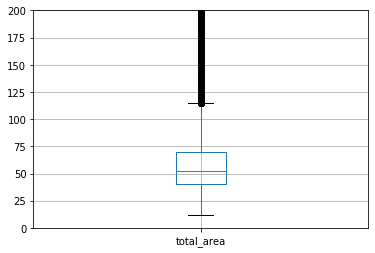

In [22]:
# для оценки показателей построим гистограммы для каждого параметра.
# data.hist('total_area',bins =100, range = (0,400)) # основная масса распределяется в диапазоне 30-115 кв м
data.boxplot('total_area')
plt.ylim(0, 200)

(0, 15000000)

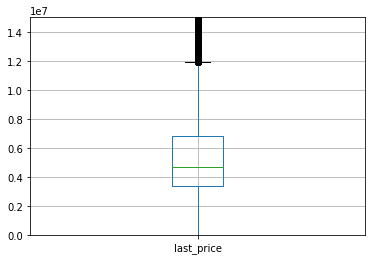

In [23]:
# data.hist('last_price',bins = 100,range =(500000,50000000) ) # среднее стремиться к 6500 тыс. руб.
data.boxplot('last_price')
plt.ylim(0, 15000000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f77b9aed0>]],
      dtype=object)

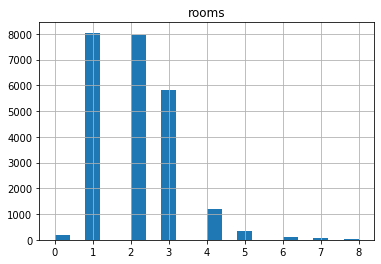

In [24]:
data.hist('rooms',bins =20, range = (0,8))# однушки, двушки, трешки в ходу

(0, 5)

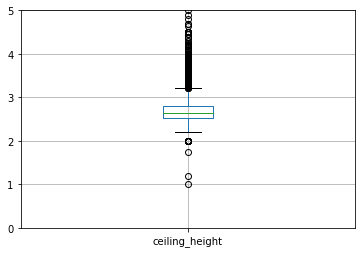

In [25]:
# data['ceiling_height'].hist(bins=20,range =(2,5))# потолки распределяются от  1.5 до знатных 5.5 метров, все же стандарт 2.50 -2.60
data.boxplot('ceiling_height')# есть какие-то аномальные выбросы, их в  выборку включать не будем
plt.ylim(0, 5)

**Вывод** В целом, можно сказать, что люди проживают на площади от 30-115 кв.м., 50 % населения проживает от 45-70 кв.м.. В основном, квартиры  стоят до 12 млн рублей, мидианное значение  4,650,000 руб. Классика комнат от 1 до 4. Потолки распределяются от  1.5 до знатных 5.5 метров, все же стандарт 2.50 -2.60 (рулоны обоев обычно продают по 10 метров, что неудобно при поклейке, если потолок 2.6 :()

### Оценка временного срока продажи квартиры 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f77ac8110>]],
      dtype=object)

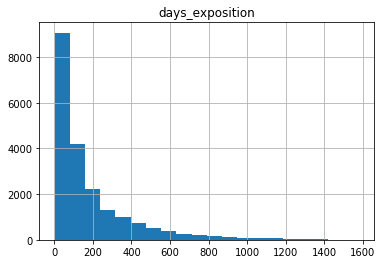

In [26]:
data.hist('days_exposition',bins=20) # Построим гистограмму

In [27]:
data.days_exposition.describe()# Посчитаем среднее и медиану.

count   20518.00
mean      180.89
std       219.73
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

(0, 600)

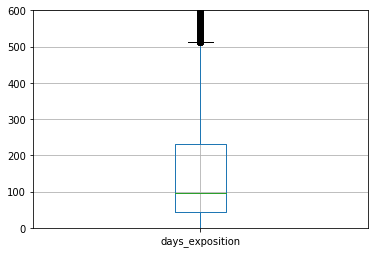

In [28]:
data.boxplot('days_exposition')
plt.ylim(0, 600)

**Выводы:** в среднем, мы видим , что квартиры продаются в  течение 1-3 месяцев (75%), есть необычно быстрые продажи в течение одного дня, а есть которые стоят годами, в частности максимальное значение  4,3 года (1580 дней)

<!-- data.query('days_exposition < 500').describe() -->

### Оценка зависимости цены от этажа (первом, последнем или другом) 

In [29]:
spb_cat_floor = data.query('locality_name == "Санкт-Петербург"').pivot_table(index ='category_floor', values ='last_price',aggfunc = 'mean')
# not_spb_cat_floor = data.pivot_table(index ='category_floor', values ='last_price',aggfunc = ['mean',lambda x:lovely_format(x.mean())])
not_spb_cat_floor = data.pivot_table(index ='category_floor', values ='last_price',aggfunc ='mean')
consolidated_cat_floor = spb_cat_floor.merge(not_spb_cat_floor, how = "left", on = "category_floor")
# consolidated_cat_floor.rename(columns={'last_price_x': 'средняя цена СПБ', 
#                                           'last_price_y': 'средняя цена не СПБ'}, inplace=True)
# consolidated_cat_floor.plot(kind = 'bar',title ='Зависимость цены от этажа')
# consolidated_cat_floor['средняя цена СПБ'] = consolidated_cat_floor['средняя цена СПБ'].apply(lovely_format)
consolidated_cat_floor


,last_price_x,last_price_y
category_floor,,
другой,7747629.40,6411745.52
первый,6342500.00,2788200.00
последний,10351731.45,7361024.84


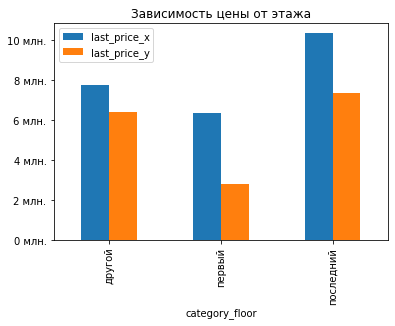

In [30]:
ax = consolidated_cat_floor.plot(kind = 'bar',title ='Зависимость цены от этажа')
ax.set_yticklabels(['{:,.0f}'.format(x/10**6) + ' млн.' for x in ax.get_yticks()])
plt.show()

**Вывод:** Средняя стоимость зависит от этажа квартиры, первые этажи особо не любят, берут ценой, разница существенная в два раза. Если говорить отдельно про СПБ, средняя стоимость верхних этажей дороже, чем все остальные.

### Оценка факторов, которые влияют на стоимость квартиры.  

Рассмотрим пары
- цена от площади
- цена от числа комнат
- цена удалённости от центра 

In [31]:
price_sqr = data.pivot_table(index = 'total_area' , values=['last_price'], aggfunc='mean').astype(int)
stat_multi = data.reset_index().pivot_table(index = ['index'],values=['last_price','cityCenters_nearest','rooms','total_area'], aggfunc='sum')
stat_multi.corr()

,cityCenters_nearest,last_price,rooms,total_area
cityCenters_nearest,1.00,-0.05,-0.06,-0.08
last_price,-0.05,1.00,0.36,0.65
rooms,-0.06,0.36,1.00,0.76
total_area,-0.08,0.65,0.76,1.00


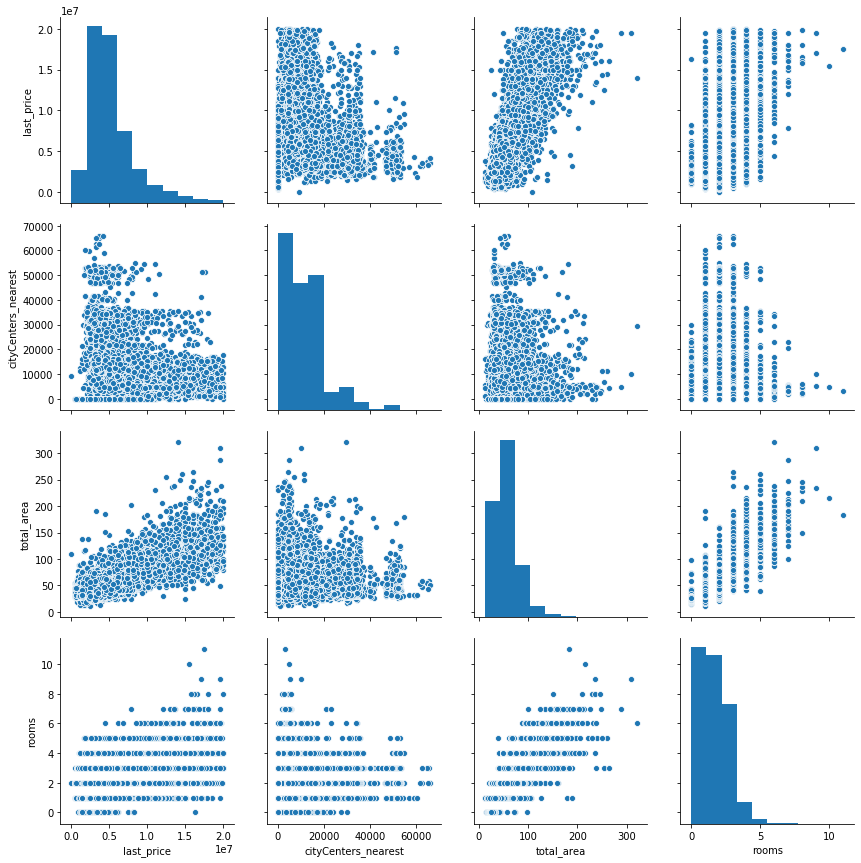

In [32]:
# pd.plotting.scatter_matrix(stat_multi.query('last_price<10000000'), figsize=(16, 10),alpha=0.07) # построим матрицу рассеиния, согласно наших пар, постораемся увидеть линейную зависимость
# price_sqr.sort_values('last_price',ascending=False)
sns.pairplot(stat_multi.query('last_price<20000000'),x_vars=["last_price", "cityCenters_nearest", "total_area","rooms"], y_vars=["last_price", "cityCenters_nearest", "total_area","rooms"], height=3)

**Вывод**
- пара цена от площадь - корреляция (0.65) очевидна.Стоимость жилья зависит от ее площади. Но все же, есть прочие факторы, которые влияют на стоимость квартиры.
- пара цена от числа комнат - корреляция(0.36) - слабая. Логично ,что увеличиние числа комнат влечет рост площади, что повлечет к удорожанию. Но , также видно, что  есть сильный рост стоимости внутри групп по комнатам, этто свидетельствует,о том что есть еще прочие факторы , которые ведут к росту стоимости жилья.  
- пара цена удалённости от центра - слабая линейная коррреляция(0.08), но, в целом, видные какие- то бакеты нужно более детально смотреть

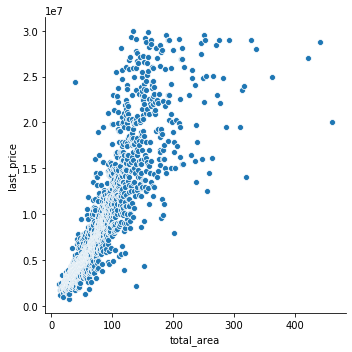

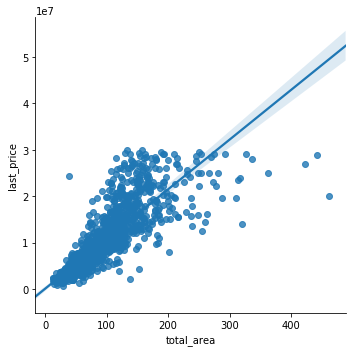

In [33]:

price_sqr.corr()# посомтрим линейный коэффициент корреляции Пирсона lmplot
sns.relplot(data=price_sqr.reset_index().query('last_price<30000000'), x="total_area", y="last_price")  # постоим график линейной зависимости площади квартиры от стоимости цены.
# sns.rugplot(data=price_sqr.reset_index().query('last_price<30000000'), x="total_area", y="last_price",height=.1) # тут в терминале ошибка rugplot() missing 1 required positional argument: 'a', в домашнем терминале все норм. Пока закооментировал.
sns.lmplot(data=price_sqr.reset_index().query('last_price<30000000'), x="total_area", y="last_price") # постоим график линейной зависимости площади квартиры от стоимости цены.

**Вывод:** еще раз продемонстрирована линейная зависимость стоимости жилья от площади.


### Оценка динамики стоимости квартир в течение 2014-2019 гг

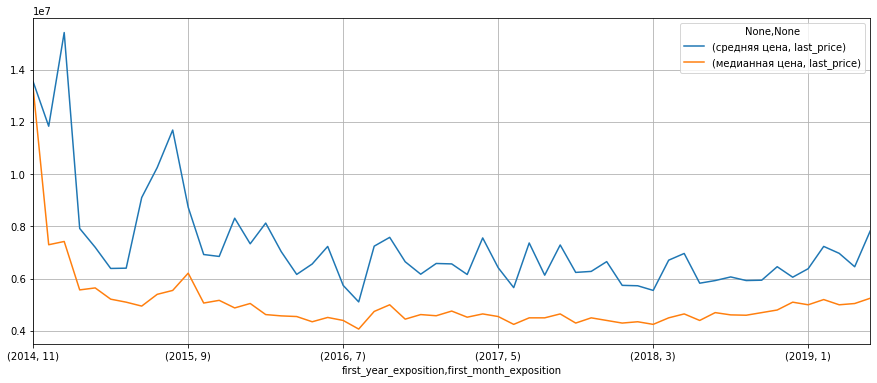

In [34]:
consolidated_table_price = data.pivot_table(index=['first_year_exposition','first_month_exposition'], values='last_price', aggfunc=['mean','median']).astype('int64')
consolidated_table_price.rename(columns={'mean': 'средняя цена', 
                                          'median': 'медианная цена'}, inplace=True)
consolidated_table_price.plot(grid=True,figsize=(15, 6),legend=True)


**Вывод:** В целом, если говорить о изменении динамики стоимости жилья во времени, то можно сказать , что было сильное  падение стоимости жилья, после ноября 2014 года. Всему виной экономические изменения, которые происходили в  стране. Резкая  девольвация рубля привела к падению покупательной способности населения. После долгой стагнации в экономике страны, наблюдается оттепель с середины 2018 намечается, виден трегд на рост стоимости жилья.  

### Оценка ТОП 10 населённых пунктов с наибольшим числом объявлений. 
- Посчитаем среднюю цену квадратного метра в этих населённых пунктах.
- Выделим среди них населённые пункты (locality_name)с самой высокой и низкой стоимостью жилья.

In [35]:
top_locality_name = data.pivot_table(index ='locality_name', values ='index',aggfunc = 'count').sort_values('index',ascending=False).head(10)
price_sqr_m_locality_name = data.pivot_table(index ='locality_name', values ='price_sqr_m',aggfunc = 'mean')
pivot_top_locality_name = top_locality_name.merge(price_sqr_m_locality_name, how='left', on ='locality_name')
pivot_top_locality_name = pivot_top_locality_name.sort_values('price_sqr_m', ascending=False)
# pivot_top_locality_name.style.background_gradient(cmap='YlGn', subset = 'price_sqr_m').format(thousands=" ")
# pivot_top_locality_name.style.format('{:,.1f}',thousand=" ").background_gradient(cmap='YlGn',subset = 'price_sqr_m')
pivot_top_locality_name=pivot_top_locality_name.style.background_gradient(axis=0,cmap='YlGn', subset = 'price_sqr_m').format('{:,.2f}')
pivot_top_locality_name

,index,price_sqr_m
locality_name,,
Санкт-Петербург,"15,721.00","114,849.01"
Пушкин,369.00,"103,125.82"
деревня Кудрово,299.00,"92,473.55"
посёлок Парголово,327.00,"90,175.91"
посёлок Мурино,522.00,"85,752.19"
посёлок Шушары,440.00,"78,677.36"
Колпино,338.00,"75,424.58"
Гатчина,307.00,"68,746.15"
Всеволожск,398.00,"68,654.47"


**Вывод:** очевидно, что наибольшая концентрация  объявлений в  северной столице, средняя стоимость квадрата отличается почти в  два раза м между  ТОП10 населенных пунктов

### Оценка стоимости квартиры в зависимости удалености от центра

- выделим квартиры в Санкт-Петербурге 
- посчитаем среднюю цену для каждого километра
- построем график зависимости цены от от удалённости от центра
    - определим какая область входит в центр
    - определим границу, где график сильно меняет, тем самым определим, что считается центром

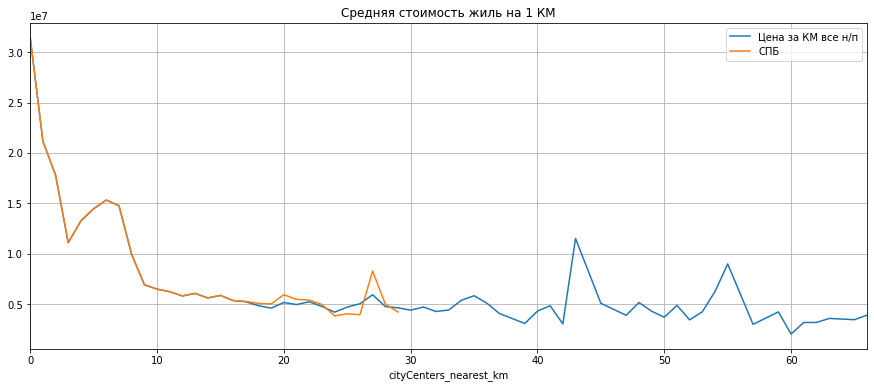

In [36]:
data_spb = data.query('locality_name == "Санкт-Петербург"')# выделим квартиры в Санкт-Петербурге
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0) #Создадим столбец с расстоянием до центра в километрах
price_for_km =data.groupby(data['cityCenters_nearest_km']).agg({'last_price':'mean'})# сгруппируем по всем населенным пунктам.
price_for_km_spb =data_spb.groupby(data['cityCenters_nearest_km']).agg({'last_price':'mean'})# сгруппируем по СПБ
consolidated_table_price_for_km = price_for_km.merge(price_for_km_spb,how = "left", on = 'cityCenters_nearest_km')
consolidated_table_price_for_km.rename(columns={'last_price_x': 'Цена за КМ все н/п', 
                                          'last_price': 'Цена за КМ СПБ',
                                          'last_price_y': 'СПБ'}, inplace=True)
consolidated_table_price_for_km.plot(grid=True,figsize=(15, 6),legend=True, title = "Средняя стоимость жиль на 1 КМ")

**Вывод** цена  сильно падает в  отдалении от центра свыше 9 км, сам СПБ заканчивается на 30 Км. 

####  Оценка количества продаж по дням недели

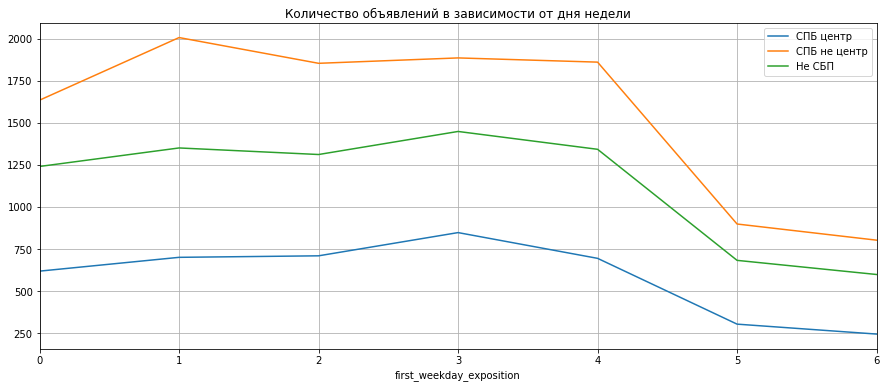

In [37]:
spb_not_center_weekday =data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km>9').pivot_table(index=['first_weekday_exposition'], values='last_price', aggfunc='count').astype('int64')
village_weekday = data.query('locality_name != "Санкт-Петербург"').pivot_table(index='first_weekday_exposition', values='last_price', aggfunc='count').astype('int64')
spb_center_weekday = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').pivot_table(index=['first_weekday_exposition'], values='last_price', aggfunc='count').astype('int64')
consolidated_weekday_table = spb_center_weekday.merge(spb_not_center_weekday, how = "left", on = 'first_weekday_exposition').merge(village_weekday, how = "left", on = 'first_weekday_exposition')
consolidated_weekday_table.rename(columns={'last_price_x': 'СПБ центр', 
                                          'last_price': 'Не СБП',
                                          'last_price_y': 'СПБ не центр'}, inplace=True)
consolidated_weekday_table.plot(grid=True,figsize=(15, 6),legend=True, title = "Количество объявлений в зависимости от дня недели")

**Вывод:** логично, что основная активность по купле-продаже просиходит в будние дни и к выходным затихает. Смотреть средную цену или медиану нецелесообразно, какую-либо динамику изменения цены мы не увидим.

####  Оценка средней стоимости жилья  от месяца года

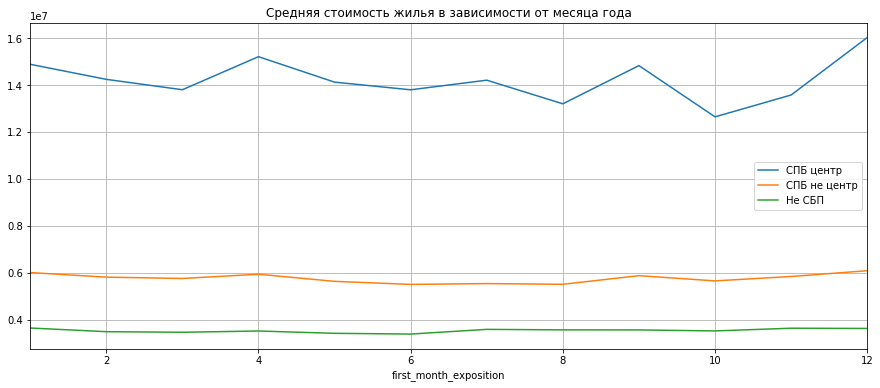

In [38]:
spb_center=data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').pivot_table(index=['first_month_exposition'], values='last_price', aggfunc='mean').astype('int64')
spb_not_center = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km>9').pivot_table(index=['first_month_exposition'], values='last_price', aggfunc='mean').astype('int64')
village = data.query('locality_name != "Санкт-Петербург"').pivot_table(index=['first_month_exposition'], values='last_price', aggfunc='mean').astype('int64')
consolidated_month_table = spb_center.merge(spb_not_center, how = "left", on = 'first_month_exposition').merge(village, how = "left", on = 'first_month_exposition')
consolidated_month_table.rename(columns={'last_price_x': 'СПБ центр', 
                                          'last_price': 'Не СБП',
                                          'last_price_y': 'СПБ не центр'}, inplace=True)# соберем все таблички в одну и сделаем названия  столбцов понятными
consolidated_month_table.plot(grid=True,figsize=(15, 6),legend=True, title = "Средняя стоимость жилья в зависимости от месяца года")


**Вывод** по средней стоимости жилься можно увидеть, что к концу весны и до осени цена падает и середины осени снова начинает расти, так как в стране возрастает деловая активность.

####  Оценка динамики стоимости жилья по годам

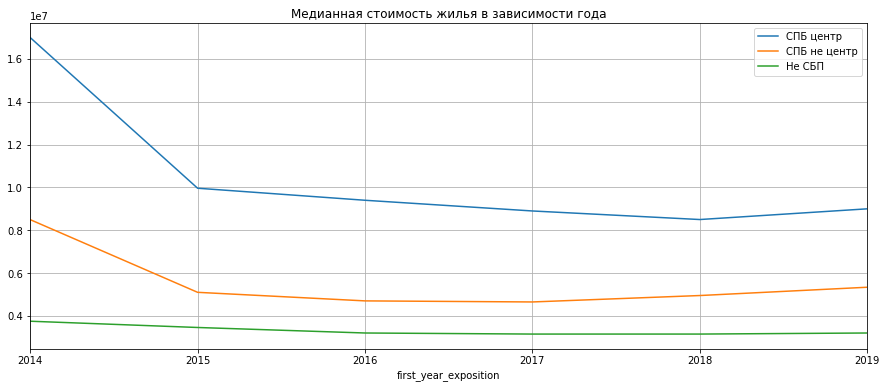

In [39]:
spb_not_center_year = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km>9').pivot_table(index=['first_year_exposition'], values='last_price', aggfunc='median').astype('int64')
spb_center_year = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').pivot_table(index=['first_year_exposition'], values='last_price', aggfunc='median').astype('int64')
village_year = data.query('locality_name != "Санкт-Петербург"').pivot_table(index=['first_year_exposition'], values='last_price', aggfunc='median').astype('int64')
consolidated_year_table =  spb_center_year.merge(spb_not_center_year, how = "left", on = 'first_year_exposition').merge(village_year, how = "left", on = 'first_year_exposition')
consolidated_year_table.rename(columns={'last_price_x': 'СПБ центр', 
                                          'last_price': 'Не СБП',
                                          'last_price_y': 'СПБ не центр'}, inplace=True)# соберем все таблички в одну и сделаем названия  столбцов понятными
consolidated_year_table.plot(grid=True,figsize=(15, 6),legend=True, title = "Медианная стоимость жилья в зависимости года")

**Вывод** после политического кризиза в конце 2014 года цена сильно просела в СПБ, не так  сильно она снизилась за пределами СПБ. Но также видно, что цена с 2018 более быстро набирает обороты в северной   столице чем в регионе.

###  Оценка квартир в центре СПБ

 - оценка частотности: площадь, цена, число комнат, высота потолков.
 - проверка корреляций стоимость квартиры число: комнат, этажа, удалённость от центра, даты размещения объявления

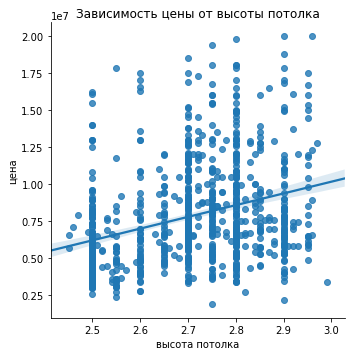

In [40]:
stat_multi_spb = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','cityCenters_nearest','ceiling_height','floor'], aggfunc='sum')
price_ceiling_height= data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','ceiling_height'], aggfunc='sum')
sns.lmplot(data=price_ceiling_height.reset_index().query('2.4<ceiling_height<3 and last_price <20000000'), x="ceiling_height", y="last_price").set(title ='Зависимость цены от высоты потолка',xlabel='высота потолка',ylabel='цена')


**Вывод:** Есть слабая линейная зависимость, чем выше потолок тем цена выше.

,last_price,rooms
last_price,1.00,0.34
rooms,0.34,1.00


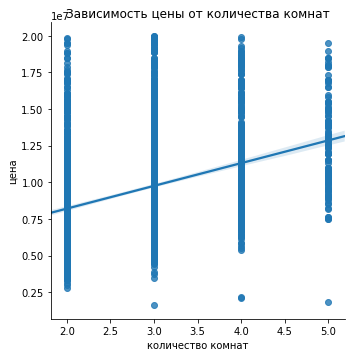

In [41]:
price_room = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','rooms'], aggfunc='sum')
sns.lmplot(data=price_room.reset_index().query('1<rooms<6 and last_price <20000000'), x="rooms", y="last_price").set(title ='Зависимость цены от количества комнат',xlabel='количество комнат',ylabel='цена')
price_room.corr()

**Вывод:** Есть линейная зависимость, чем больше комнат больше площадь, больше цена

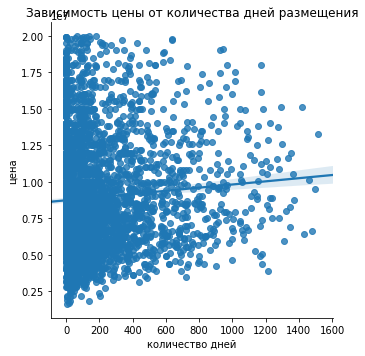

In [42]:
price_days_exposition = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','days_exposition'], aggfunc='sum')
sns.lmplot(data=price_days_exposition.reset_index().query('last_price <20000000'), x="days_exposition", y="last_price").set(title ='Зависимость цены от количества дней размещения',xlabel='количество дней',ylabel='цена')


**Вывод:** есть слабая линейная зависимость, по большей части в догий срок висят в продаже  экслюзиные варианты, они конечно, обладают более низкой ликвидностью. Полагаю данный фактор принимать во внимание ене стоит.

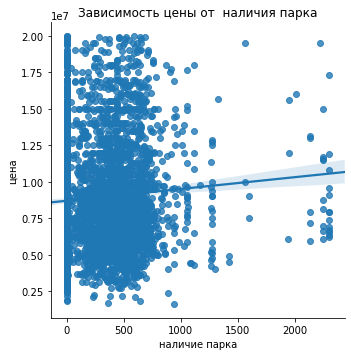

In [43]:
price_parks_nearest= data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','parks_nearest'], aggfunc='sum')
sns.lmplot(data=price_parks_nearest.reset_index().query('last_price <20000000'), x="parks_nearest", y="last_price").set(title ='Зависимость цены от  наличия парка',xlabel='наличие парка',ylabel='цена')


**Вывод:** есть слабая линейная зависимость,но можно отменить ,что наличие прака незначительно увеличивает рост стоимости жилья.

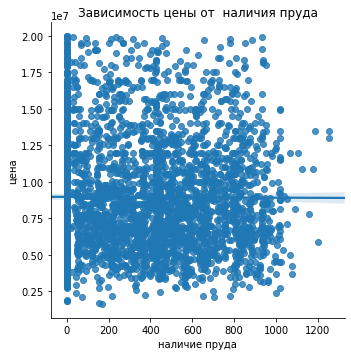

In [44]:
price_ponds_nearest= data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km<9').reset_index().pivot_table(index = ['index'],values=['last_price','ponds_nearest'], aggfunc='sum')
sns.lmplot(data=price_ponds_nearest.reset_index().query('last_price <20000000'), x="ponds_nearest", y="last_price").set(title ='Зависимость цены от  наличия пруда',xlabel='наличие пруда',ylabel='цена')

**Вывод:** есть слабая линейная зависимость,но с прудом дела обстоят хуже, он немного одешевляет стоимость жилья.

## Общий вывод

По результатам анализа можно сделать вывод,что на  цену квартиры  влияет много фаторов. К основным факторам относятся площадь квартиры,очевидно, что чем больше площадь,тем дороже квартира.Близость к центру также не маловажный фактор,средняя цена квартиры  на один км за близость к центру  начинает улетать в космос от 9 Км. Этажность - в центре СПБ люди готовы заплатить на 30% больше за высокий этаж.Потолки также не маловажный фактор, за 3-х меторые потолки, рынок просит больше на 50%, чем за стандарт 2.5-2.6. Количество комнат также влечет увелечение стоимости, но не всегда, лишь когда это сопряжено с ростом общей площади. Наличие парков также влечет рост стоимости жилья, а вот пруды почему-то не очень.